In [1]:
import time
import cv2
import os
import random
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils
import matplotlib.image as mpimg
from collections import OrderedDict
from skimage import io, transform
from math import *
import xml.etree.ElementTree as ET 

import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from torchvision import datasets, models, transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
data_bbox = np.load('/content/drive/MyDrive/helen_finale/data_bbox.npy',)
data_names = np.load('/content/drive/MyDrive/helen_finale/data_names.npy')
data_attenction = np.load('/content/drive/MyDrive/helen_finale/data_attenction.npy')
print(data_bbox.size)
print(data_names.size)
print(data_bbox[1])
print(data_attenction.size)

487680
5080
[[489 335]
 [476 320]
 [461 335]
 [474 349]
 [310 339]
 [296 325]
 [281 338]
 [295 352]
 [217 166]
 [553 634]
 [553 166]
 [217 634]
 [396 166]
 [444 168]
 [484 179]
 [519 200]
 [539 229]
 [550 263]
 [553 298]
 [551 341]
 [548 382]
 [543 421]
 [536 462]
 [524 505]
 [510 541]
 [493 566]
 [471 588]
 [453 604]
 [433 618]
 [409 630]
 [378 634]
 [347 629]
 [323 617]
 [302 602]
 [283 586]
 [260 565]
 [244 540]
 [231 505]
 [222 461]
 [218 419]
 [217 378]
 [218 338]
 [221 295]
 [228 260]
 [243 226]
 [268 198]
 [306 178]
 [347 168]]
5080


0


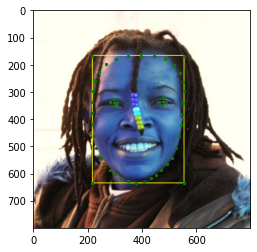

In [12]:
im=cv2.imread(('/content/drive/MyDrive/helen_finale/train_1/'+data_names[1]))
plt.imshow(im)
plt.scatter(data_bbox[1][:,0], data_bbox[1][:,1], s = 5, c = 'g') 
plt.imshow(cv2.rectangle(im, (data_bbox[1][8,0], data_bbox[1][8,1]), (data_bbox[1][9,0], data_bbox[1][9,1]), (255, 255, 0), 2))
print(data_attenction[1])

In [13]:
class Transforms():
    def __init__(self):
        pass
    
    def rotate(self, image, landmarks, angle):
        angle = random.uniform(-angle, +angle)

        transformation_matrix = torch.tensor([
            [+cos(radians(angle)), -sin(radians(angle))], 
            [+sin(radians(angle)), +cos(radians(angle))]
        ])

        image = imutils.rotate(np.array(image), angle)

        landmarks = landmarks - 0.5
        new_landmarks = np.matmul(landmarks, transformation_matrix)
        new_landmarks = new_landmarks + 0.5
        return Image.fromarray(image), new_landmarks

    def resize(self, image, landmarks, img_size):
        image = TF.resize(image, img_size)
        return image, landmarks

    def color_jitter(self, image, landmarks):
        color_jitter = transforms.ColorJitter(brightness=0.4, 
                                              contrast=0.4,
                                              saturation=0.4, 
                                              hue=0.2)
        image = color_jitter(image)
        return image, landmarks

    def crop_face(self, image, landmarks,crops):
        left = int(crops[0])
        top =  int(crops[1])
        width = int(crops[2])
        height = int(crops[3])


       # image = TF.crop(image, top, left, height, width)

        img_shape = np.array(image).shape
        landmarks = torch.tensor(landmarks) # - torch.tensor([[left, top]])
        landmarks = landmarks / torch.tensor([img_shape[1], img_shape[0]])
        return image, landmarks

    def __call__(self, image, landmarks, crops):
        image = Image.fromarray(image)
        image, landmarks = self.crop_face(image, landmarks, crops)
        image, landmarks = self.resize(image, landmarks, (224, 224))
        image, landmarks = self.color_jitter(image, landmarks)
        image, landmarks = self.rotate(image, landmarks, angle=90)
        
        image = TF.to_tensor(image)
        image = TF.normalize(image, [0.5], [0.5])
        return image, landmarks

In [16]:
class FaceLandmarksDataset(Dataset):

    def __init__(self, df_names, df_bbox, transform=None):

        self.image_filenames = []
        self.landmarks = []
        self.crops = []
        self.transform = transform
        
        for filename in df_names:
            self.image_filenames.append("/content/drive/MyDrive/helen_finale/train_1/"+filename)
            
        posizione=0
        for num in df_bbox:
             landmark = []
             crop=[]
             for i in range(48):
               if(i<8 or i>9):
                  x_coordinate = int(num[i][0])
                  y_coordinate = int(num[i][1])
                  landmark.append([x_coordinate, y_coordinate])
             if(data_attenction[posizione]==1):
               landmark.append([0, 500])   
             else:
               landmark.append([0, 0])
             self.landmarks.append(landmark)

             
             crop.append(int(num[8][0]))
             crop.append(int(num[8][1]))
             crop.append((int(num[9][0])-int(num[8][0])))
             crop.append((int(num[9][1])-int(num[8][1])))

             self.crops.append(crop)

             posizione+=1
            
        self.landmarks = np.array(self.landmarks).astype('float32')     

        assert len(self.image_filenames) == len(self.landmarks)

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, index):
        #print(self.image_filenames[index])
        image = cv2.imread(self.image_filenames[index], 0)
        landmarks = self.landmarks[index]
        
        if self.transform:
            image, landmarks = self.transform(image, landmarks, self.crops[index])

        landmarks = landmarks - 0.5

        return image, landmarks

dataset = FaceLandmarksDataset(data_names,data_bbox,Transforms())
#qua metti la cosa per il test set fatta da te con le tue foto

tensor([[103.4382,  82.2089],
        [ 98.2477,  84.2043],
        [100.7636,  89.5890],
        [105.6908,  87.4981],
        [ 87.3928, 129.7705],
        [ 82.3701, 132.1249],
        [ 84.3595, 137.3188],
        [ 89.3822, 134.9643],
        [ 65.0630,  49.2171],
        [156.1669, 182.4266],
        [ 50.0661,  90.5984],
        [ 55.1776,  78.1376],
        [ 61.8942,  68.6440],
        [ 70.7656,  61.4223],
        [ 80.3102,  58.9175],
        [ 90.3113,  59.2618],
        [ 99.8114,  61.8102],
        [110.9400,  66.4396],
        [121.4465,  71.1418],
        [131.2355,  76.1804],
        [141.3599,  81.9369],
        [151.5332,  89.2021],
        [159.6728,  96.3266],
        [164.6301, 103.1924],
        [168.3200, 111.0899],
        [170.8126, 117.3607],
        [172.5876, 123.9679],
        [173.4540, 131.4385],
        [171.5459, 139.9909],
        [167.2685, 147.6848],
        [161.8170, 152.8658],
        [155.8624, 156.9698],
        [149.8355, 160.4513],
        [1

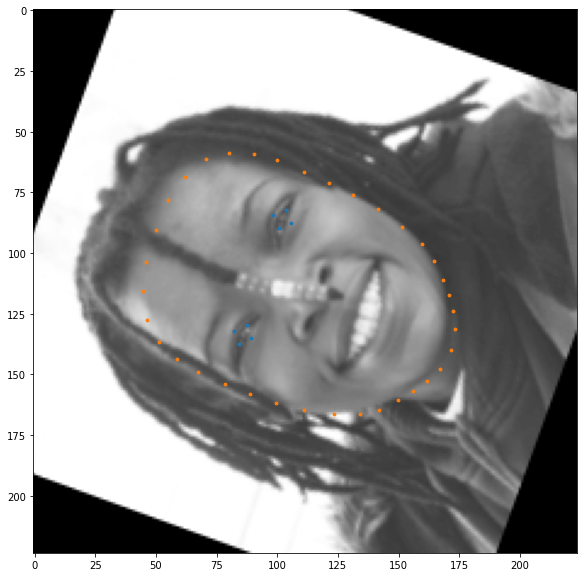

In [17]:
image, landmarks = dataset[1]
landmarks = (landmarks + 0.5) * 224
plt.figure(figsize=(10, 10))
plt.imshow(image.numpy().squeeze(), cmap='gray');
plt.scatter(landmarks[:8,0], landmarks[:8,1], s=8);  
plt.scatter(landmarks[10:46,0], landmarks[10:46,1], s=8);

print(landmarks) 

In [22]:
# split the dataset into validation and test sets
len_valid_set = int(0.1*len(dataset))
len_test_set = int(0.05*len(dataset))
len_train_set = len(dataset) - len_valid_set -len_test_set

print("The length of Train set is {}".format(len_train_set))
print("The length of Valid set is {}".format(len_valid_set))
print("The length of Test set is {}".format(len_test_set))

train_dataset , valid_dataset, test_dataset= torch.utils.data.random_split(dataset , [len_train_set, len_valid_set, len_test_set])

# shuffle and batch the datasets
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2) #64->16
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=254, shuffle=True, num_workers=2) #64->16
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=32, shuffle=True, num_workers=2) 

The length of Train set is 4318
The length of Valid set is 508
The length of Test set is 254


In [23]:
images, landmarks = next(iter(train_loader))

print(images.shape)
print(landmarks.shape)

torch.Size([64, 1, 224, 224])
torch.Size([64, 47, 2])


In [24]:
class Network(nn.Module):
    def __init__(self,num_classes=94): #num_classe 16->1
        super().__init__()
        self.model_name='resnet50'
        self.model=models.resnet50()
        self.model.conv1=nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False) 
        self.model.fc=nn.Linear(self.model.fc.in_features, num_classes)
        
    def forward(self, x):
        x=self.model(x)
        return x

In [25]:
import sys

def print_overwrite(step, total_step, loss, operation):
    sys.stdout.write('\r')
    if operation == 'train':
        sys.stdout.write("Train Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))   
    else:
        sys.stdout.write("Valid Steps: %d/%d  Loss: %.4f " % (step, total_step, loss))
        
    sys.stdout.flush()

Valid Steps: 16/16  Loss: 0.0082 
--------------------------------------------------
Epoch: 1  Train Loss: 0.0119  Valid Loss: 0.0082
--------------------------------------------------

Minimum Validation Loss of 0.0082 at epoch 1/30
Model Saved

Valid Steps: 16/16  Loss: 0.0078 
--------------------------------------------------
Epoch: 2  Train Loss: 0.0076  Valid Loss: 0.0078
--------------------------------------------------

Minimum Validation Loss of 0.0078 at epoch 2/30
Model Saved

Valid Steps: 16/16  Loss: 0.0064 
--------------------------------------------------
Epoch: 3  Train Loss: 0.0065  Valid Loss: 0.0064
--------------------------------------------------

Minimum Validation Loss of 0.0064 at epoch 3/30
Model Saved

Valid Steps: 16/16  Loss: 0.0053 
--------------------------------------------------
Epoch: 4  Train Loss: 0.0056  Valid Loss: 0.0053
--------------------------------------------------

Minimum Validation Loss of 0.0053 at epoch 4/30
Model Saved

Valid Steps:

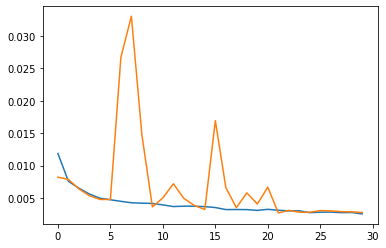

In [26]:
torch.autograd.set_detect_anomaly(True)
network = Network()
network.cuda()    

state= torch.load("/content/drive/MyDrive/helen_finale/Soluzione_resnet50_noCrop.pth") #per secondo giro
network.load_state_dict(state) #per secondo giro

criterion = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=0.0001)

loss_min = np.inf
num_epochs = 30

loss_train_graph=[]
loss_valid_graph=[]

start_time = time.time()
for epoch in range(1,num_epochs+1):
    
    loss_train = 0
    loss_valid = 0
    running_loss = 0
    
    network.train()
    for step in range(1,len(train_loader)+1):
    
        images, landmarks = next(iter(train_loader))
        
        images = images.cuda()
        landmarks = landmarks.view(landmarks.size(0),-1).cuda() 
        
        predictions = network(images)
        
        # clear all the gradients before calculating themdeep-learning pytorch

        optimizer.zero_grad()
        
        # find the loss for the current step
        loss_train_step = criterion(predictions, landmarks)
        
        # calculate the gradients
        loss_train_step.backward()
        
        # update the parameters
        optimizer.step()
        
        loss_train += loss_train_step.item()
        running_loss = loss_train/step
        
        print_overwrite(step, len(train_loader), running_loss, 'train')
        
    network.eval() 
    with torch.no_grad():
        
        for step in range(1,len(valid_loader)+1):
            
            images, landmarks = next(iter(valid_loader))
        
            images = images.cuda()
            landmarks = landmarks.view(landmarks.size(0),-1).cuda()
        
            predictions = network(images)

            # find the loss for the current step
            loss_valid_step = criterion(predictions, landmarks)

            loss_valid += loss_valid_step.item()
            running_loss = loss_valid/step

            print_overwrite(step, len(valid_loader), running_loss, 'valid')
    
    loss_train /= len(train_loader)
    loss_valid /= len(valid_loader)
    loss_train_graph.append(loss_train)
    loss_valid_graph.append(loss_valid)

    print('\n--------------------------------------------------')
    print('Epoch: {}  Train Loss: {:.4f}  Valid Loss: {:.4f}'.format(epoch, loss_train, loss_valid))
    print('--------------------------------------------------')
    
    if loss_valid < loss_min:
        loss_min = loss_valid
        torch.save(network.state_dict(), '/content/face_landmarks.pth') 
        print("\nMinimum Validation Loss of {:.4f} at epoch {}/{}".format(loss_min, epoch, num_epochs))
        print('Model Saved\n')

torch.save(network.state_dict(), '/content/ultimo.pth')      
print('Training Complete')
print("Total Elapsed Time : {} s".format(time.time()-start_time))

plt.plot(loss_train_graph)

plt.plot(loss_valid_graph)

Mediapipe dice di no
Pytorch dice attento
right
Mediapipe dice attento
Pytorch dice attento
left
Mediapipe dice attento
Pytorch dice attento
left
Mediapipe dice attento
Pytorch dice attento
attento
Mediapipe dice attento
Pytorch dice attento
right
Mediapipe dice di no
Pytorch dice di no
attento
Mediapipe dice attento
Pytorch dice attento
attento
Mediapipe dice attento
Pytorch dice attento
attento


accuracy dell'attention regola base è {} 0.7480314960629921
accuracy dell'attention regola geometrica è {} 0.562992125984252


accuracy del landamark è {} 0.9777007817628681
Total number of test images: 254
Elapsed Time : 76.21123600006104


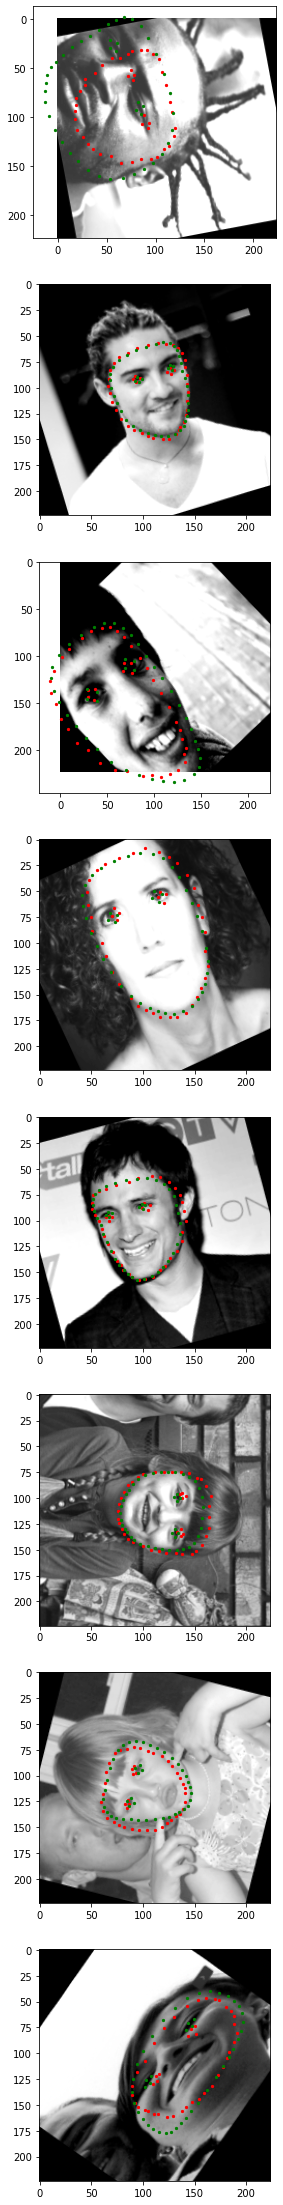

In [27]:
import math

start_time = time.time()

with torch.no_grad():

    best_network = Network()
    best_network.cuda()
    best_network.load_state_dict(torch.load('/content/Soluzione_resnet50_noCrop_secondoGiro_imgRuotate90.pth')) 
    best_network.eval()
    
    images, landmarks = next(iter(test_loader))
    images = images.cuda()
    landmarks = (landmarks + 0.5) * 224
                   
    predictions = (best_network(images).cpu() + 0.5) * 224
    predictions = predictions.view(-1,47,2) #secondo 16->1

    plt.figure(figsize=(10,40))
    mediapipe=""
    pytorch=""
    giusti=[]
    predetti=[]
    valore_base=0
    valore_geom=0
    numeri_att=[17,39,0,6]
    

    for img_num in range(254): #da cambiare in base alla grandezza del test set
        if img_num<8:
          plt.subplot(8,1,img_num+1)
          plt.imshow(images[img_num].cpu().numpy().transpose(1,2,0).squeeze(), cmap='gray')
          plt.scatter(predictions[img_num,:8,0], predictions[img_num,:8,1], c = 'r', s = 5)
          plt.scatter(landmarks[img_num,:8,0], landmarks[img_num,:8,1], c = 'g', s = 5)
          plt.scatter(predictions[img_num,10:46,0], predictions[img_num,10:46,1], c = 'r', s = 5)
          plt.scatter(landmarks[img_num,10:46,0], landmarks[img_num,10:46,1], c = 'g', s = 5)
          #plt.scatter(landmarks[img_num,17,0], landmarks[img_num,17,1], c = 'g', s = 5)
          #plt.scatter(landmarks[img_num,39,0], landmarks[img_num,39,1], c = 'g', s = 5)
          #plt.scatter(landmarks[img_num,0,0], landmarks[img_num,0,1], c = 'g', s = 5)
          #plt.scatter(landmarks[img_num,6,0], landmarks[img_num,6,1], c = 'g', s = 5)
          
        
        for i in range(46):
          giusti.append(landmarks[img_num,i,0].item())
          giusti.append(landmarks[img_num,i,1].item())
          predetti.append(predictions[img_num,i,0].item())
          predetti.append(predictions[img_num,i,1].item())
              
        distance_r=math.sqrt((predictions[img_num,17,0].item()-predictions[img_num,0,0].item())**2+(predictions[img_num,17,1].item()-predictions[img_num,0,1].item())**2)
        distance_l=math.sqrt((predictions[img_num,39,0].item()-predictions[img_num,6,0].item())**2+(predictions[img_num,39,1].item()-predictions[img_num,6,1].item())**2)
        dist=distance_r/distance_l

        if((landmarks[img_num,46,1]).item()>0):
          if img_num<8: 
            print("Mediapipe dice attento")
          mediapipe="attento"
        else:
          if img_num<8: 
            print("Mediapipe dice di no")
          mediapipe="no"
        
        if((predictions[img_num,46,1]).item()>0):
          if img_num<8: 
            print("Pytorch dice attento")
          pytorch="attento"
        else:
          if img_num<8: 
            print("Pytorch dice di no")  
          pytorch="no"  
  
        if(pytorch==mediapipe):
          valore_base+=1
              
        dist=distance_r/distance_l
        if dist>1.5:
          if img_num<8: 
            print("right")
          pytorch="no"  
        elif(dist<0.5):
          if img_num<8: 
            print("left")
          pytorch="no"  
        else:
          if img_num<8: 
            print("attento")
          pytorch="attento"  
        #print(dist)  
        if(pytorch==mediapipe):
          valore_geom+=1

    print("\n")
        
    print("accuracy dell'attention regola base è {}",valore_base/254)    
    print("accuracy dell'attention regola geometrica è {}",valore_geom/254)   
    print("\n")  
    
    somma=[]
    totale=0
    for i in range(len(giusti)):
      a=(giusti[i]-predetti[i])/224
      if a<0:
        a=-a
      somma.append(a)
    for elem in somma:
      totale+=elem
    totale=totale/254
    totale=1-totale/100 
    print("accuracy del landamark è {}", totale)
print('Total number of test images: {}'.format(len(test_dataset)))

end_time = time.time()
print("Elapsed Time : {}".format(end_time - start_time)) 

geom dice attento
modello dice attento


<Figure size 2880x2880 with 0 Axes>

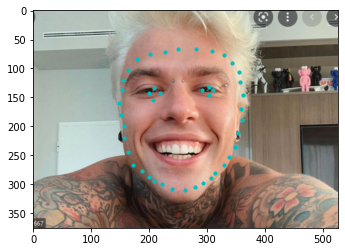

In [29]:

import time
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import imutils

import torch
import torch.nn as nn
from torchvision import models
import torchvision.transforms.functional as TF
#######################################################################
image_path = '/content/drive/MyDrive/helen_finale/test_Att/Screenshot from 2022-08-30 04-33-31.png'
weights_path = '/content/Soluzione_resnet50_noCrop_secondoGiro_imgRuotate90.pth'
#frontal_face_cascade_path = 'haarcascade_frontalface_default.xml'
#######################################################################

#######################################################################
#face_cascade = cv2.CascadeClassifier(frontal_face_cascade_path)

best_network = Network()
best_network.load_state_dict(torch.load(weights_path, map_location=torch.device('cpu'))) 
best_network.eval()

image = cv2.imread(image_path)
grayscale_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
display_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
height, width,_ = image.shape

#faces = face_cascade.detectMultiScale(grayscale_image, 1.1, 4)
x=0
y=0
w=width
h=height
#all_landmarks = []
#for (x, y, w, h) in faces:
image = grayscale_image[y:y+h, x:x+w]
image = TF.resize(Image.fromarray(image), size=(224, 224))
image = TF.to_tensor(image)
image = TF.normalize(image, [0.5], [0.5])

with torch.no_grad():
    landmarks = best_network(image.unsqueeze(0)) 

landmarks = (landmarks.view(47,2).detach().numpy() + 0.5) * np.array([[w, h]]) + np.array([[x, y]])
#all_landmarks.append(landmarks)
plt.figure(figsize=(40,40))
plt.figure()
plt.imshow(display_image)
#for landmarks in all_landmarks:
plt.scatter(landmarks[:8,0], landmarks[:8,1], c = 'c', s = 10)
plt.scatter(landmarks[10:46,0], landmarks[10:46,1], c = 'c', s = 10)

distance_r=math.sqrt((landmarks[17,0].item()-landmarks[0,0].item())**2+(landmarks[17,1].item()-landmarks[0,1].item())**2)
distance_l=math.sqrt((landmarks[39,0].item()-landmarks[6,0].item())**2+(landmarks[39,1].item()-landmarks[6,1].item())**2)
dist=distance_r/distance_l
if dist>1.5:
    print("geom dice right")
    pytorch="no"  
elif(dist<0.5):
    print("geom dice left")
    pytorch="no"  
else:
    print("geom dice attento")
    pytorch="attento"  
if((landmarks[46,1]).item()>0):
    print("modello dice attento")
    mediapipe="attento"
else:  
    print("modello dice di no")
    mediapipe="no"
        
plt.show()